## Purpose
1. To prevent gradients vanishing with depth each layer is connected directly with every preceding layer.
2. To develop an architecture that would efficiently reuse needed features rather than relearning them.

## Perceived Advantages
1. Higher parameter efficieny due to layers not having to explicitly preserve previously learned features in order to pass them on to subsequent layers.
2. Ease of information/gradient flow as every layer is connected to every other layers
3. A regularizing effect
    * Is it because of the increased variation in the inputs for each layer due to concatenation from previous layers?
    * Is it because of the efficient usage of parameters thereby requiring fewer parameters in general?
    * The authors found that between the same pooling layers, resnets using stochastic depth leads to a similar connectivity pattern, hence can densenets also be described as an ensemble of varied depth networks in some sense?
4. Implicit deep supervision

## Methodology
In this study we implement 3 denseblocks with dilated convolutions used instead of pooling


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as tfunc
from torch.utils.data import dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
%matplotlib inline

In [2]:
mnist_X = torchvision.datasets.MNIST("./mnist",train=True,download=True,transform=torchvision.transforms.ToTensor())
mnist_length = mnist_X.__len__()
mnist_train,mnist_val = dataset.random_split(mnist_X,[int(0.9*mnist_length),mnist_length-int(0.9*mnist_length)])
mnist_test = torchvision.datasets.MNIST("./mnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

fmnist_X = torchvision.datasets.FashionMNIST("./fmnist",train=True,download=True,transform=torchvision.transforms.ToTensor())
fmnist_length = fmnist_X.__len__()
fmnist_train,fmnist_val = dataset.random_split(fmnist_X,[int(0.9*fmnist_length),fmnist_length-int(0.9*fmnist_length)])
fmnist_test = torchvision.datasets.FashionMNIST("./fmnist",train=False,download=True,transform=torchvision.transforms.ToTensor())

emnist_X = torchvision.datasets.EMNIST("./emnist",split='balanced',train=True,download=True,transform=torchvision.transforms.ToTensor())
emnist_length = emnist_X.__len__()
emnist_train,emnist_val = dataset.random_split(emnist_X,[int(0.9*emnist_length),emnist_length-int(0.9*emnist_length)])
emnist_test = torchvision.datasets.EMNIST("./emnist",split='balanced',train=False,download=True,transform=torchvision.transforms.ToTensor())

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(10,(0.02,0.02)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.ToTensor()
])

svhn_X = torchvision.datasets.SVHN('./svhn', split='train',download=True, transform=torchvision.transforms.ToTensor())
svhn_length = svhn_X.__len__()
svhn_train,svhn_val = dataset.random_split(svhn_X,[int(0.9*svhn_length),svhn_length-int(0.9*svhn_length)])
svhn_test = torchvision.datasets.SVHN("./svhn",split='test',download=True,transform=torchvision.transforms.ToTensor())

Using downloaded and verified file: ./svhn\train_32x32.mat
Using downloaded and verified file: ./svhn\test_32x32.mat


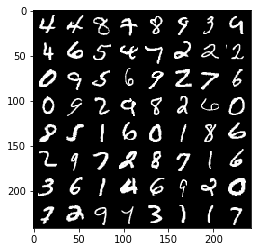

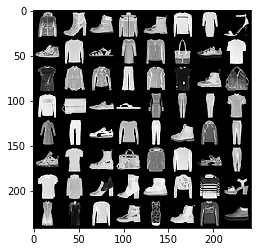

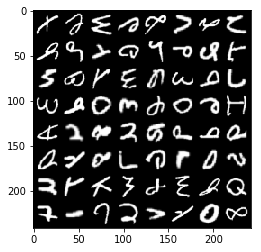

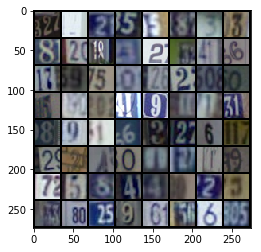

In [3]:
def imshow(dataset) :
    inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)))
    inp = torchvision.utils.make_grid(inp)
    plt.imshow(inp.permute(1, 2,0))
    plt.show()
imshow(mnist_train)
imshow(fmnist_train)
imshow(emnist_train)
imshow(svhn_train)

In [4]:
import torch.optim as optim
def train(net,lr,wd,dataset,loss_fn) :
    net.train()
    optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=wd)
    for x,y in dataset :
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_pred = net(x)
        loss_fn(y_pred,y).backward()
        optimizer.step()

def inference(net,dataset,loss_fn) :
    loss = 0
    with torch.no_grad() :
        net.eval()
        for x,y in dataset :
            x = x.cuda()
            y = y.cuda()
            y_pred = net(x)
            loss += loss_fn(y_pred,y).detach().cpu().numpy().item()
    return loss/dataset.dataset.__len__()

def run_epoch(net,lr,batch_size,train_dataset,val_dataset,test_dataset,train_loss,val_loss,max_epochs,wd=0) :
    train_losses = []
    val_losses = []
    test_losses = []
    train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=batch_size)
    
    for i in range(max_epochs+1) :
        train(net,lr,wd,train_loader,train_loss)
        if i%5 == 0:
            train_losses.append(inference(net,train_loader,val_loss))
            val_losses.append(inference(net,val_loader,val_loss))
            test_losses.append(inference(net,test_loader,val_loss))
            print("epoch : {},train_loss : {:.2f},val_loss : {:.2f},test_loss : {:.2f}".format(i,train_losses[-1],val_losses[-1],test_losses[-1]))
    return train_losses,val_losses,test_losses
       

In [5]:
class DenseLayer(nn.Sequential) :
    def __init__(self,channels,growth_rate,dilation,compression_factor=4) :
        super(DenseLayer,self).__init__()
        self.add_module("norm0",nn.BatchNorm2d(channels))
        self.add_module("compression",nn.Conv2d(channels,channels//4,1,padding=0,dilation=1))
        self.add_module("activation0",nn.ReLU(inplace=True))
        channels = channels//4
        self.add_module("norm1",nn.BatchNorm2d(channels))
        self.add_module("hidden0",nn.Conv2d(channels,growth_rate,3,padding=dilation,dilation=dilation))
        self.add_module("activation1",nn.ReLU(inplace=True))
class DCNet(nn.Module) :
    def __init__(self,init_channels=1,initial_filters = 16,blocks = [3,6,6], growth_rate = 12, num_classes=10) :
        super(DCNet,self).__init__()
        self.initial_conv = nn.Sequential(nn.Conv2d(init_channels,initial_filters,3,padding=1),nn.ReLU(inplace=True))
        in_channels = initial_filters
        self.blocks = nn.ModuleList()
        for i,n_layers in enumerate(blocks) :
            layers = nn.ModuleList()
            for j in range(n_layers) :
                layer = DenseLayer(in_channels,growth_rate,dilation = 2**i)
                layers.append(layer)
                in_channels += growth_rate
            self.blocks.append(layers)
        self.classifier = nn.Sequential(nn.Conv2d(in_channels,num_classes,1),nn.ReLU())
        
    def forward(self,x,debug=False) :
        x = self.initial_conv(x)
        debug_outs = []
        depth = len(self.blocks)
        inputs = x
        for i,block in enumerate(self.blocks) :
            for layer in block :
                x = layer(inputs)
                inputs = torch.cat([inputs,x],dim=1)
        debug_outs.append(inputs)
        x = self.classifier(inputs)
        debug_outs.append(x)
        x = x.view(x.shape[0],x.shape[1],-1).mean(dim=2)
        debug_outs.append(x)
        return x if not debug else debug_outs

In [6]:
def zero_one_loss(y_pred,y_true) :
    indices = torch.argmax(y_pred,dim=1,keepdim=True).type_as(y_true)
    y_true = y_true.view(-1,1)
    return torch.sum(torch.eq(indices-y_true,0))

epoch : 0,train_loss : 0.87,val_loss : 0.87,test_loss : 0.88
epoch : 5,train_loss : 0.98,val_loss : 0.98,test_loss : 0.98
epoch : 10,train_loss : 0.99,val_loss : 0.98,test_loss : 0.98
epoch : 15,train_loss : 0.99,val_loss : 0.99,test_loss : 0.98
epoch : 20,train_loss : 1.00,val_loss : 0.99,test_loss : 0.99
epoch : 25,train_loss : 1.00,val_loss : 0.99,test_loss : 0.99
epoch : 30,train_loss : 1.00,val_loss : 0.99,test_loss : 0.99
epoch : 35,train_loss : 1.00,val_loss : 0.99,test_loss : 0.99
epoch : 40,train_loss : 1.00,val_loss : 0.99,test_loss : 0.99


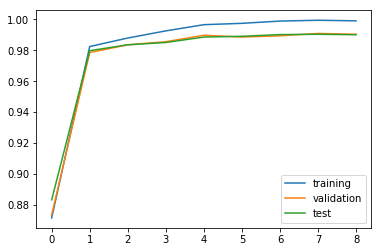

In [7]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
mnist_net = DCNet().cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
mtr,mv,mte = run_epoch(mnist_net,1e-4,128,mnist_train,mnist_val,mnist_test,train_loss,val_loss,40,0)
plt.plot(mtr)
plt.plot(mv)
plt.plot(mte)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(mnist_net.state_dict(),'mnist_net_dcn.mod')

epoch : 0,train_loss : 0.73,val_loss : 0.72,test_loss : 0.72
epoch : 5,train_loss : 0.85,val_loss : 0.84,test_loss : 0.84
epoch : 10,train_loss : 0.90,val_loss : 0.89,test_loss : 0.89
epoch : 15,train_loss : 0.92,val_loss : 0.90,test_loss : 0.90
epoch : 20,train_loss : 0.93,val_loss : 0.90,test_loss : 0.90
epoch : 25,train_loss : 0.93,val_loss : 0.90,test_loss : 0.90
epoch : 30,train_loss : 0.95,val_loss : 0.91,test_loss : 0.91
epoch : 35,train_loss : 0.94,val_loss : 0.90,test_loss : 0.90
epoch : 40,train_loss : 0.94,val_loss : 0.90,test_loss : 0.90


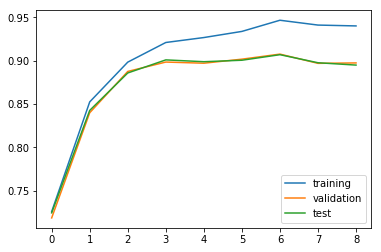

In [8]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
fmnist_net = DCNet().cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
ftr,fv,fte = run_epoch(fmnist_net,1e-4,128,fmnist_train,fmnist_val,fmnist_test,train_loss,val_loss,40,0)
plt.plot(ftr)
plt.plot(fv)
plt.plot(fte)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(fmnist_net.state_dict(),'fmnist_net_dcn.mod')

epoch : 0,train_loss : 0.48,val_loss : 0.46,test_loss : 0.46
epoch : 5,train_loss : 0.83,val_loss : 0.82,test_loss : 0.82
epoch : 10,train_loss : 0.87,val_loss : 0.86,test_loss : 0.86
epoch : 15,train_loss : 0.88,val_loss : 0.87,test_loss : 0.87
epoch : 20,train_loss : 0.89,val_loss : 0.87,test_loss : 0.87
epoch : 25,train_loss : 0.89,val_loss : 0.88,test_loss : 0.88
epoch : 30,train_loss : 0.90,val_loss : 0.88,test_loss : 0.88
epoch : 35,train_loss : 0.90,val_loss : 0.88,test_loss : 0.88
epoch : 40,train_loss : 0.90,val_loss : 0.89,test_loss : 0.88


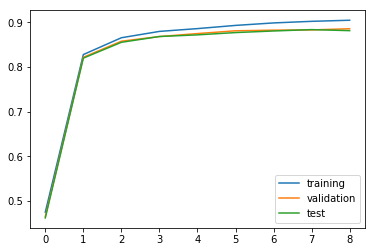

In [9]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
emnist_net = DCNet(num_classes=47).cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss
etr,ev,ete = run_epoch(emnist_net,1e-4,128,emnist_train,emnist_val,emnist_test,train_loss,val_loss,40,0.0)
plt.plot(etr)
plt.plot(ev)
plt.plot(ete)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(emnist_net.state_dict(),'emnist_net_dcn.mod')

epoch : 0,train_loss : 0.33,val_loss : 0.33,test_loss : 0.35
epoch : 5,train_loss : 0.89,val_loss : 0.88,test_loss : 0.87
epoch : 10,train_loss : 0.93,val_loss : 0.92,test_loss : 0.92
epoch : 15,train_loss : 0.94,val_loss : 0.92,test_loss : 0.92
epoch : 20,train_loss : 0.96,val_loss : 0.92,test_loss : 0.93
epoch : 25,train_loss : 0.96,val_loss : 0.93,test_loss : 0.93
epoch : 30,train_loss : 0.97,val_loss : 0.92,test_loss : 0.93
epoch : 35,train_loss : 0.98,val_loss : 0.93,test_loss : 0.93
epoch : 40,train_loss : 0.98,val_loss : 0.93,test_loss : 0.93


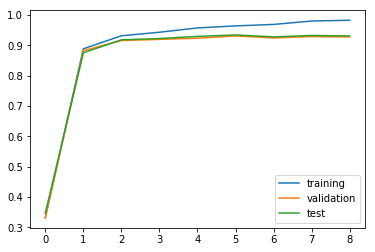

In [10]:
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
svhn_net = DCNet(init_channels=3).cuda()
train_loss = nn.CrossEntropyLoss()
val_loss = zero_one_loss 
svtr,svv,svte = run_epoch(svhn_net,1e-4,64,svhn_train,svhn_val,svhn_test,train_loss,val_loss,40,0)
plt.plot(svtr)
plt.plot(svv)
plt.plot(svte)
plt.legend(['training','validation','test'],loc='lower right')
plt.show()
torch.save(svhn_net.state_dict(),'svhn_net_dcn.mod')

In [29]:
def imshow_features(net,dataset,num_iters) :
    net.eval()
    for i in range(num_iters) :
        print("\n\n\n\nDisplaying Input")
        inp,_ = next(iter(torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=True)))
        inpu = inp.squeeze().numpy()
        if len(inpu.shape) == 3 :
            plt.imshow(np.transpose(inpu,[1,2,0]))
        else :
            plt.imshow(inpu,cmap='gray')
        plt.show()
        debug_outs = net(inp.cuda(),debug=True)
        print("Displaying Activations")
        for out in debug_outs[0:-1] :
            out = torch.transpose(out.cpu().detach(),0,1)
            inp = torchvision.utils.make_grid(out,nrow=16)
            plt.imshow(inp.permute(1, 2,0))
            plt.show()





Displaying Input


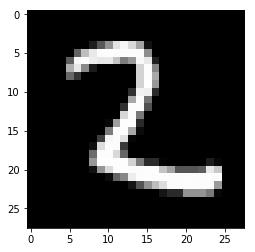

Displaying Activations


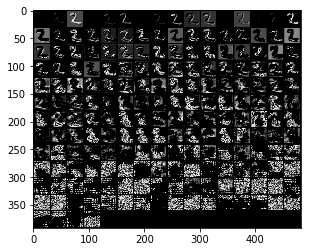

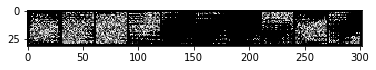





Displaying Input


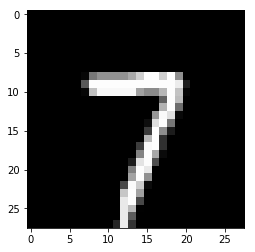

Displaying Activations


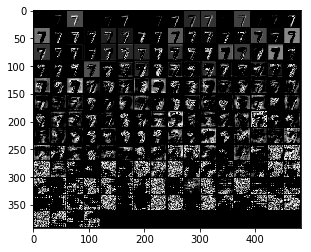

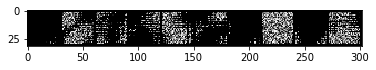





Displaying Input


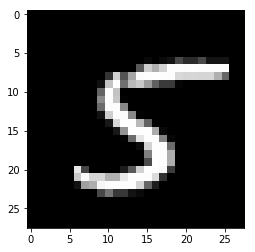

Displaying Activations


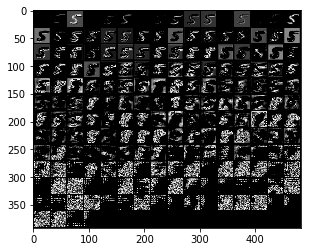

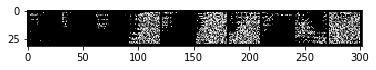





Displaying Input


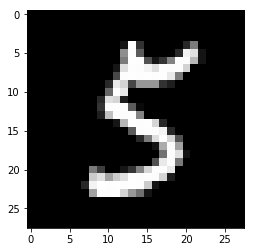

Displaying Activations


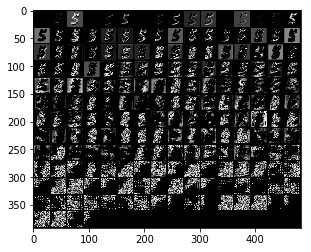

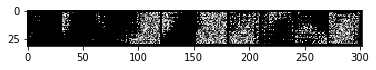





Displaying Input


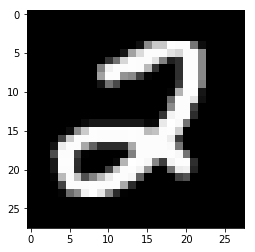

Displaying Activations


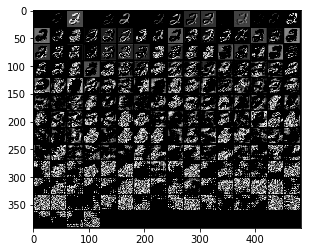

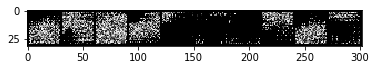

In [30]:
imshow_features(mnist_net,mnist_test,5)





Displaying Input


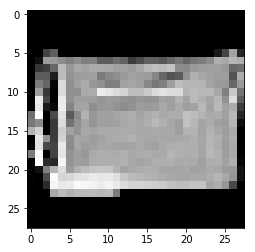

Displaying Activations


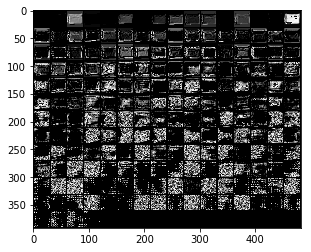

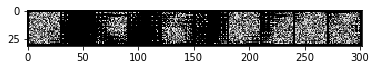





Displaying Input


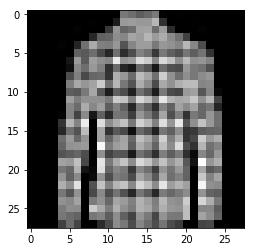

Displaying Activations


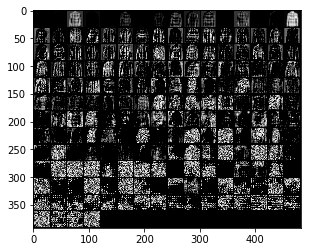

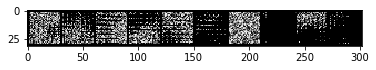





Displaying Input


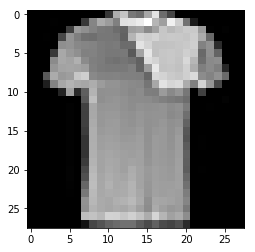

Displaying Activations


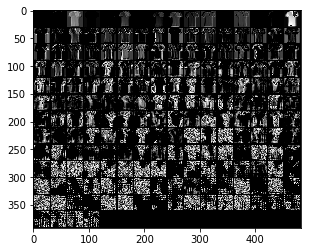

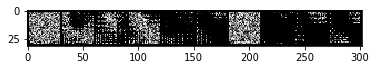





Displaying Input


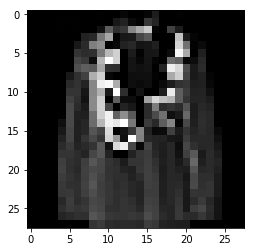

Displaying Activations


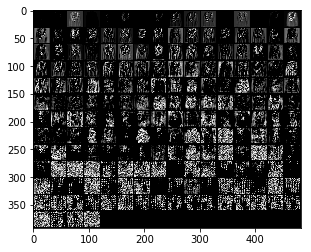

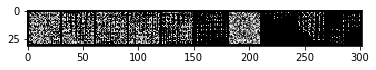





Displaying Input


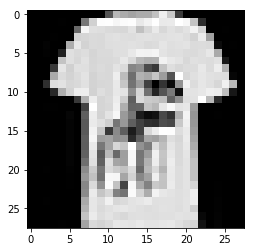

Displaying Activations


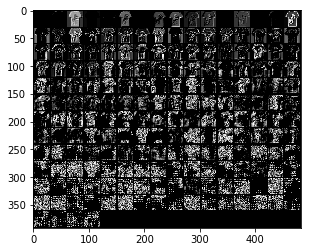

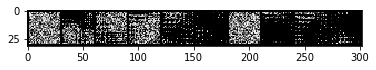

In [31]:
imshow_features(fmnist_net,fmnist_test,5)





Displaying Input


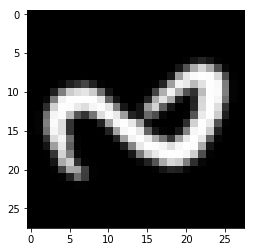

Displaying Activations


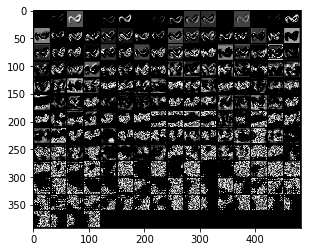

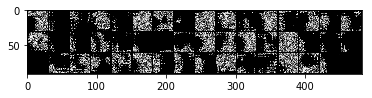





Displaying Input


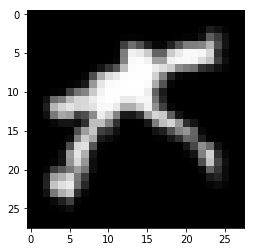

Displaying Activations


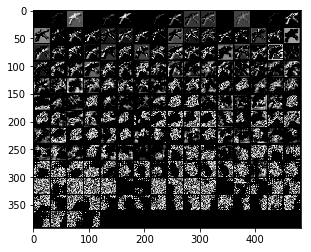

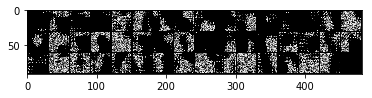





Displaying Input


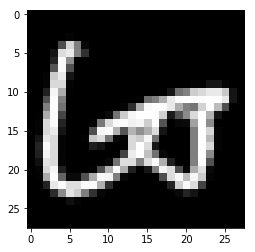

Displaying Activations


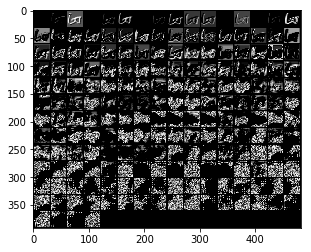

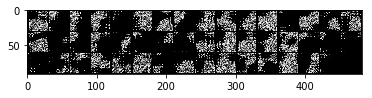





Displaying Input


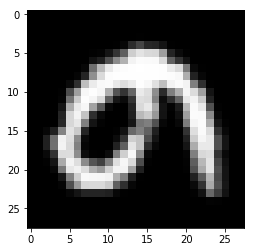

Displaying Activations


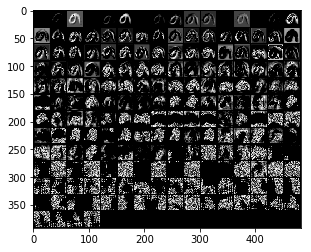

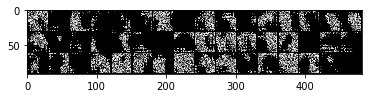





Displaying Input


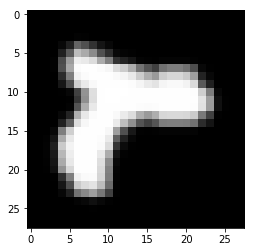

Displaying Activations


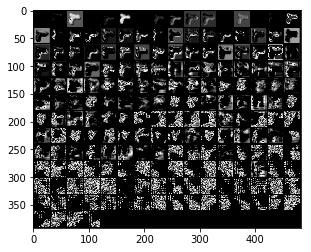

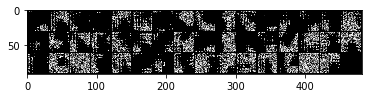

In [32]:
imshow_features(emnist_net,emnist_test,5)





Displaying Input


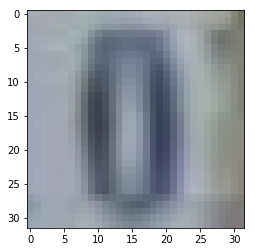

Displaying Activations


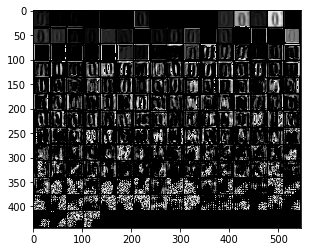

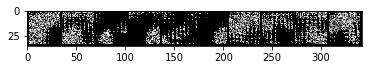





Displaying Input


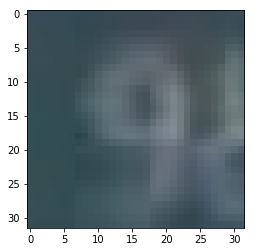

Displaying Activations


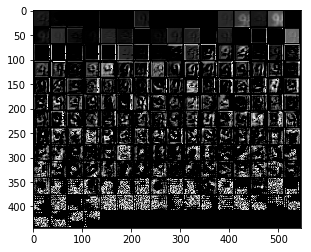

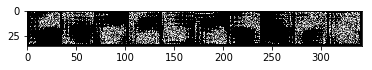





Displaying Input


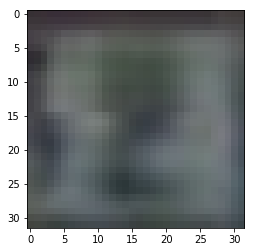

Displaying Activations


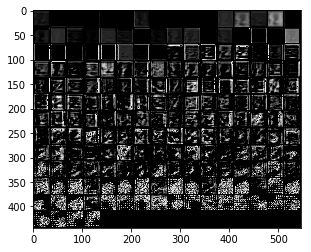

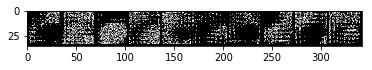





Displaying Input


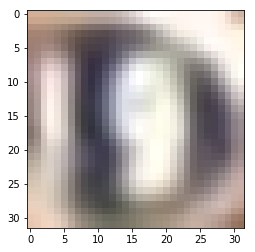

Displaying Activations


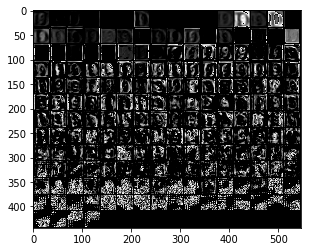

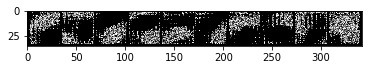





Displaying Input


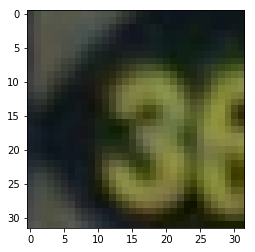

Displaying Activations


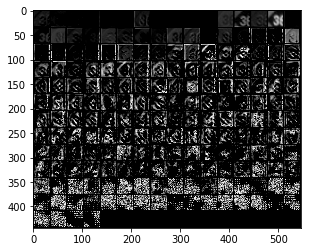

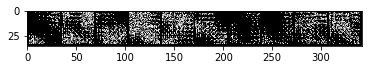

In [33]:
imshow_features(svhn_net,svhn_test,5)

In [45]:
def display_weights(layer) :
    weights = layer.weight.detach().cpu().numpy()
    n_o,n_i = weights.shape[0:2]
    weights = weights.reshape((n_o,n_i,-1))
    mean_l1_norm = np.abs(weights).sum(axis=-1)
    plt.imshow(mean_l1_norm)
    plt.show()

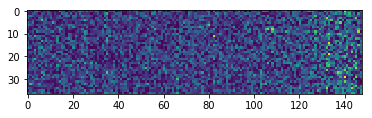

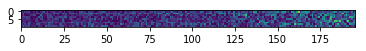

In [46]:
display_weights(mnist_net.blocks[-1][2][1])
display_weights(mnist_net.classifier[0])

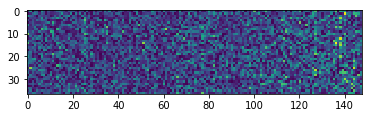

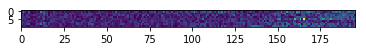

In [47]:
display_weights(fmnist_net.blocks[-1][2][1])
display_weights(fmnist_net.classifier[0])

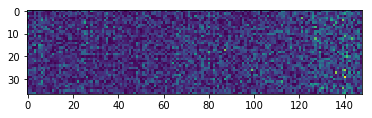

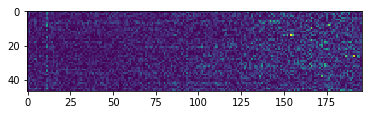

In [49]:
display_weights(emnist_net.blocks[-1][2][1])
display_weights(emnist_net.classifier[0])

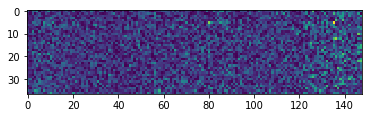

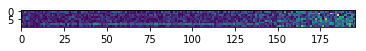

In [50]:
display_weights(svhn_net.blocks[-1][2][1])
display_weights(svhn_net.classifier[0])

### Results and Discussion
In mnist dataset the network achieves nearly perfect accuracy. For the FMnist,EMnist and SVHN dataset the network achieves approximately 90%,88% and 93% respectively.
During the course of training the above models, It was noticed that the network needed batch normalization to train well. There do not seem to be duplicate features being learnt in the network and the final convolutions seem to use all the features but the weightage is leaning towards recently learned filters. In the classifier most of the weight is concentrated around the final features that were learnt.

### References
[Densely connected convolutional networks](https://arxiv.org/pdf/1608.06993.pdf)

[MNist](http://yann.lecun.com/exdb/mnist/)

[FMnist](https://github.com/zalandoresearch/fashion-mnist)

[EMnist](https://www.westernsydney.edu.au/bens/home/reproducible_research/emnist)

[SVHN](http://ufldl.stanford.edu/housenumbers/)